In [1]:
pal = [(39/255,95/255,153/255),(80/255,176/255,220/255),
       (237/255,244/255,248/255),
       (146/255,144/255,142/255),
       (78/255,78/255,80/255),
(235/255,154/255,88/255),(87/255,126/255,130/255)]

import matplotlib.colors as mcolors
import sklearn.cluster
import numpy as np
import argparse
import cv2

from tqdm import tqdm
import sys
sys.path.append("/Users/rcarlson/Documents/GitHub/lasagna3/snakes")
import mahotas
from ops.imports_ipython import *

import skimage
import umap.umap_ as umap
import stringdb



### Peroxisome validation

In [2]:
thresh = 500
thresh_dofind = 0

loc = "../../Zenodo_IRF3/Figure1/Supp/Peroxisome validation/20X_BFP-GFP-Cy5_Slice0/*.tif"
folder = glob(loc)
folder = np.sort(folder)[0:]
corrs0 = []
ind = 2
for i in range(len(folder)):
    site = re.findall("/(.*)_Site-(.*)", (folder)[i])[0][1].split('.')[0]
   
    data=read(folder[i])
    data[ind][data[ind] < thresh_dofind] = 0
    corrs0.append(np.corrcoef(data[0][data[0] > thresh],data[ind][data[0] > thresh])[1,0])
    

loc = "../../Zenodo_IRF3/Figure1/Supp/Peroxisome validation/20X_BFP-GFP-Cy5_Slice1/*.tif"
folder = glob(loc)
folder = np.sort(folder)[0:]
corrs1 = []
for i in range(len(folder)):
    site = re.findall("/(.*)_Site-(.*)", (folder)[i])[0][1].split('.')[0]
   
    data=read(folder[i])
    data[ind][data[ind] < thresh_dofind] = 0

    corrs1.append(np.corrcoef(data[0][data[0] > thresh],data[ind][data[0] > thresh])[1,0])



loc = "../../Zenodo_IRF3/Figure1/Supp/Peroxisome validation/20X_BFP-GFP-Cy5_Slice2/*.tif"
folder = glob(loc)
folder = np.sort(folder)[0:]
corrs2 = []
for i in range(len(folder)):
    site = re.findall("/(.*)_Site-(.*)", (folder)[i])[0][1].split('.')[0]
  
    data=read(folder[i])
    data[ind][data[ind] < thresh_dofind] = 0

    corrs2.append(np.corrcoef(data[0][data[0] > thresh],data[ind][data[0] > thresh])[1,0])
    

loc = "../../Zenodo_IRF3/Figure1/Supp/Peroxisome validation/20X_BFP-GFP-Cy5_Slice3/*.tif"
folder = glob(loc)
folder = np.sort(folder)[0:]
corrs3 = []
for i in range(len(folder)):
    site = re.findall("/(.*)_Site-(.*)", (folder)[i])[0][1].split('.')[0]
 
    data=read(folder[i])
    data[ind][data[ind] < thresh_dofind] = 0

    corrs3.append(np.corrcoef(data[0][data[0] > thresh],data[ind][data[0] > thresh])[1,0])
    
print(np.mean(corrs0),np.mean(corrs1),np.mean(corrs2),np.mean(corrs3))

0.7405570613007739 0.7119618772682066 0.7120477234152409 0.7285741020920887


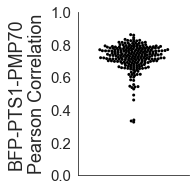

In [20]:
import textwrap
corrs = list(np.mean(np.array((corrs0,corrs1,corrs2,corrs3)),axis=0))
df=pd.DataFrame(corrs)
df.columns = ['Correlation']
df['Condition'] = 'PMP70'

plt.figure(figsize = (2,3))

sns.set_style('white')
g=sns.swarmplot(data=df, x='Condition', y='Correlation', s=3, color='k', edgecolor = 'white')
g.set(xticklabels=[])
plt.xlabel('')
plt.ylim(0,1.0)
plt.xticks(fontsize=18)
plt.yticks(fontsize=15)
plt.ylabel(textwrap.fill("BFP-PTS1-PMP70 Pearson Correlation",20),fontsize=18)
sns.despine(top=True,right=True)
plt.savefig('../../../IRF3 Paper/Figures/F1/Pex_reporter_antibody_corr.tif',dpi=300,bbox_inches='tight')

### Mapped Fractions

In [134]:
df = pd.read_csv('../Data/F1supp/genomewide_mappedfractions.csv')
df['insitu_plasmid'] = df.InSitu/df.Plasmid
df['insitu_2dox'] = df.InSitu/df['2dDox']
df['insitu_7dox'] = df.InSitu/df['7dDox']

varg=pd.read_csv('../Data/F1supp/Achilles_high_variance_genes.csv', header = None)
varg[0] = [s.split(' ')[0] for s in varg[0]]
varg.columns = ['gene_symbol']

hela = pd.read_hdf('../Data/F1supp/D2_Achilles_gene_dep_scores.hdf')
hela = hela.loc[:,['Unnamed: 0','HELA_CERVIX']]
hela.columns = ['gene_symbol', 'dependency']
hela['gene_symbol'] = [g[0][:-1] for g in hela.gene_symbol.str.split('(')]
hela = hela[hela.gene_symbol.isin((varg.gene_symbol))]


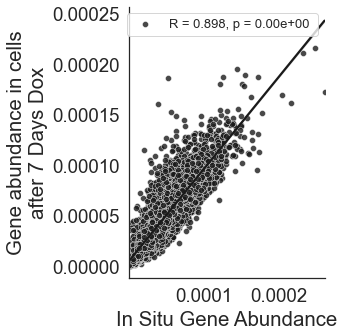

In [137]:
feature1 = 'InSitu'
feature2 = '7dDox'
nas = np.logical_or(df[feature1].isnull(), df[feature2].isnull())


plt.figure(figsize = (3.5,5))
r, p = scipy.stats.pearsonr(df[feature1][~nas],df[feature2][~nas])
sns.regplot(x = df[feature1], y = (df[feature2]), label = f'R = %s, p = {p:.2e} ' %(round(r,3)), color = 'k',
           scatter_kws={'linewidths':.5,'edgecolor':'white'})

plt.xlabel('In Situ Gene Abundance')
plt.ylabel(textwrap.fill('Gene abundance in cells after 7 Days Dox',25))
sns.despine(top = True, right = True)
plt.legend(fontsize = 13)

plt.savefig('../../../IRF3 Paper/Figures/F1/insitu_7ddoxcorr.tif',dpi=300,bbox_inches='tight')
plt.show()

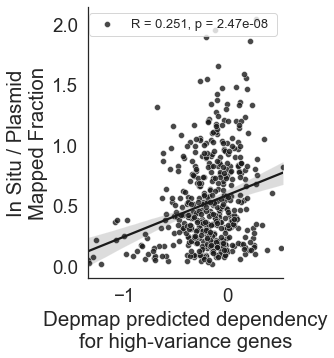

In [138]:
df = pd.merge(df, hela, on = 'gene_symbol', how = 'inner')
feature = 'insitu_plasmid'
nas = np.logical_or(df.dependency.isnull(), df[feature].isnull())

r, p = scipy.stats.pearsonr(df.dependency[~nas],df[feature][~nas])
plt.figure(figsize = (3.5,5))

sns.regplot(x = df.dependency, y = (df[feature]), label = f'R = %s, p = {p:.2e} ' %(round(r,3)), color = 'k',
           scatter_kws={'linewidths':.5,'edgecolor':'white'})

plt.xlabel(textwrap.fill('Depmap predicted dependency for high-variance genes',30))
plt.ylabel(textwrap.fill('In Situ / Plasmid Mapped Fraction',20))
sns.despine(top = True, right = True)
plt.legend(fontsize = 13)

plt.savefig('../../../IRF3 Paper/Figures/F1/depmap_rel_abundance.tif',dpi=300,bbox_inches='tight')
plt.show()

### MDA5/RIG-I/IRF3 Correlations

In [126]:
df = pd.read_hdf('../Data/TableS1.hdf')


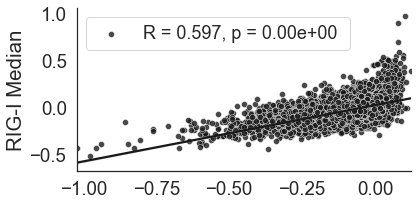

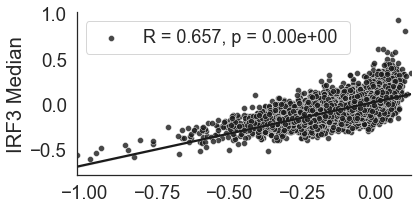

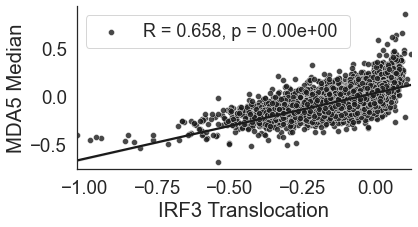

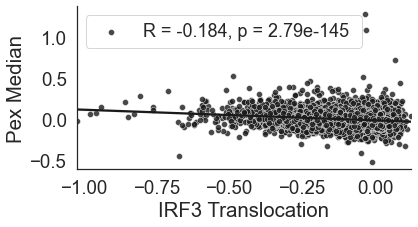

In [133]:
feature1 = 'dapi_corrch2_nuclear_corr'
feature2 = 'rig_cell_median'

nas = np.logical_or(df[feature1].isnull(), df[feature2].isnull())


plt.figure(figsize = (6,3))
r, p = scipy.stats.pearsonr(df[feature1][~nas],df[feature2][~nas])
sns.regplot(x = df[feature1], y = (df[feature2]), label = f'R = %s, p = {p:.2e} ' %(round(r,3)), color = 'k',
           scatter_kws={'linewidths':.5,'edgecolor':'white'})

plt.xlabel('')
plt.ylabel('RIG-I Median')
sns.despine(top = True, right = True)
plt.legend(fontsize = 18)

plt.savefig('../../../IRF3 Paper/Figures/F1/transloc_rig.tif',dpi=300,bbox_inches='tight')
plt.show()

feature1 = 'dapi_corrch2_nuclear_corr'
feature2 = 'irf3_cell_median'

nas = np.logical_or(df[feature1].isnull(), df[feature2].isnull())


plt.figure(figsize = (6,3))
r, p = scipy.stats.pearsonr(df[feature1][~nas],df[feature2][~nas])
sns.regplot(x = df[feature1], y = (df[feature2]), label = f'R = %s, p = {p:.2e} ' %(round(r,3)), color = 'k',
           scatter_kws={'linewidths':.5,'edgecolor':'white'})

plt.xlabel('')
plt.ylabel('IRF3 Median')
sns.despine(top = True, right = True)
plt.legend(fontsize = 18)

plt.savefig('../../../IRF3 Paper/Figures/F1/transloc_irf3.tif',dpi=300,bbox_inches='tight')
plt.show()

feature1 = 'dapi_corrch2_nuclear_corr'
feature2 = 'mda5_cell_median'

nas = np.logical_or(df[feature1].isnull(), df[feature2].isnull())


plt.figure(figsize = (6,3))
r, p = scipy.stats.pearsonr(df[feature1][~nas],df[feature2][~nas])
sns.regplot(x = df[feature1], y = (df[feature2]), label = f'R = %s, p = {p:.2e} ' %(round(r,3)), color = 'k',
           scatter_kws={'linewidths':.5,'edgecolor':'white'})

plt.xlabel('IRF3 Translocation')
plt.ylabel('MDA5 Median')
sns.despine(top = True, right = True)
plt.legend(fontsize = 18)

plt.savefig('../../../IRF3 Paper/Figures/F1/transloc_mda5.tif',dpi=300,bbox_inches='tight')
plt.show()


feature1 = 'dapi_corrch2_nuclear_corr'
feature2 = 'pex_cell_median'


plt.figure(figsize = (6,3))
r, p = scipy.stats.pearsonr(df[feature1][~nas],df[feature2][~nas])
sns.regplot(x = df[feature1], y = (df[feature2]), label = f'R = %s, p = {p:.2e} ' %(round(r,3)), color = 'k',
           scatter_kws={'linewidths':.5,'edgecolor':'white'})

plt.xlabel('IRF3 Translocation')
plt.ylabel('Pex Median')
sns.despine(top = True, right = True)
plt.legend(fontsize = 18)

plt.savefig('../../../IRF3 Paper/Figures/F1/transloc_pex.tif',dpi=300,bbox_inches='tight')
plt.show()

### Secondary-secondary correlation

In [140]:
df = pd.read_csv('../Data/TableS3.csv')
df.index = df.gene_symbol

lowhitsreporter = (df.query('fdr_bh_adj_p_secondary_reporter < .1 & mean_transloc_secondary_reporter < 0')
               .sort_values('mean_transloc_secondary_reporter').index)

highhitsreporter = (df.query('fdr_bh_adj_p_secondary_reporter < .1 & mean_transloc_secondary_reporter > 0')
                .sort_values('mean_transloc_secondary_reporter', ascending = False).index)
print(len(lowhitsreporter))
print(len(highhitsreporter))

lowhitsantibody = (df.query('fdr_bh_adj_p_secondary_antibody < .1 & mean_transloc_secondary_antibody < 0')
               .sort_values('mean_transloc_secondary_antibody').index)

highhitsantibody = (df.query('fdr_bh_adj_p_secondary_antibody < .1 & mean_transloc_secondary_antibody > 0')
                .sort_values('mean_transloc_secondary_antibody', ascending = False).index)
print(len(lowhitsantibody))
print(len(highhitsantibody))

lowhits = list(set(lowhitsantibody) & set(lowhitsreporter))
highhits = list(set(highhitsantibody) & set(highhitsreporter))
lowhits = lowhits + ['IRF3']

df = df.loc[(~pd.isnull(df.mean_transloc_secondary_reporter)) & (~pd.isnull(df.mean_transloc_secondary_antibody))]

49
56
39
56


(0.7380706721591226, 4.67190093357219e-60)


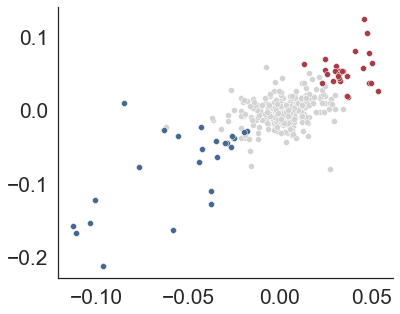

In [147]:
print(scipy.stats.pearsonr(df.mean_transloc_secondary_antibody,df.mean_transloc_secondary_reporter))



sns.set(font_scale=1.9) 
plt.figure(figsize = (6,5))
sns.set_style("white")
sns.scatterplot(x = df.mean_transloc_secondary_antibody, y = df.mean_transloc_secondary_reporter,
                color = mcolors.to_rgba('#d3d3d3'))
sns.scatterplot(x = df[df.index.isin(lowhits)].mean_transloc_secondary_antibody, y = df[df.index.isin(lowhits)].mean_transloc_secondary_reporter,
                color=pal[1])
sns.scatterplot(x = df[df.index.isin(highhits)].mean_transloc_secondary_antibody, y = df[df.index.isin(highhits)].mean_transloc_secondary_reporter,
               color=pal[0])
sns.despine(top = True, right = True)
plt.xlabel('')
plt.ylabel('')


plt.savefig('../../../IRF3 Paper/Figures/F1/secondary-secondary_corr.tif', dpi = 600, bbox_inches = 'tight')

plt.show()
